In [1]:
import warnings
import numpy as np
import pineappl

# Computing DIS structure functions numerically

Next, we want to implement the coefficient functions into a computer code to actually obtain some numbers that we can compare to the experiment which is the goal of this section. And it turns out there is yet more things to be done, aside from all the math so far. Here, we will be also concerned about numerical aspects, i.e. on how to turn the abstract ideas into actual numbers.

For DIS we need to consider
$$ e^-(l) + p(P) \to e^-(l') + X $$
and we define the usual DIS variables:
$$ q = l - l', \quad Q^2 = - q^2, \quad x = \frac{Q^2}{2q\cdot P} $$
The common observable to look at is the reduced cross section
$$ \sigma_{red}(x,Q^2) = \mathcal N \left\langle \frac{d^2\sigma^{pe^- \to e^-+X}}{dx\, dQ^2} \right\rangle \approx F_2(x,Q^2) $$
with some normalization $\mathcal N$.

After all the complication from the first part, we find at NLO accuracy
$$
  \frac 1 x F_2(x,Q^2) = \sum_a (C_a \otimes f_a^p)(x,Q^2) = \sum_a \int\limits_x^1 \frac{dz}{z} C_a(z,Q^2) f_a^p(x/z,Q^2)  = \sum_a\sum_{n=0} \left(\frac{\alpha_s(Q^2)}{4\pi}\right)^n \int\limits_x^1 \frac{dz}{z} C_a^{(n)}(z) f_a^p(x/z,Q^2)
$$
with $C_a(z) = e_a^2 c_q(z)$ for the quark channels, i.e. $a=u,\bar u,d,\bar d,s,\bar s,\ldots$,
and $C_g(z) = \langle e^2\rangle c_g(z)$ for the gluon channel, with the average squared charge $\langle e^2\rangle$.
The raw coffiecient functions are given by
$$ c_q^{(0)}(z) = \delta(1-z) \quad c_g^{(0)}(z) = 0 $$
$$ c_q^{(1)}(1) = C_F \left( 4 \left(\frac{\ln(1-z)}{1-z}\right)_+ - 3 \left(\frac{1}{1-z}\right)_+ - (6+4\zeta(2))\delta(1-z) -2(1+z)\ln((1-z)/z) -4 \frac{\ln(z)}{1-z} +6 +4z \right)  $$
$$ c_g^{(1)}(z) = 2 T_R n_f \left((2-4z(1-z)\ln((1-z)/z)) -2 +16z(1-z)\right) $$

*Further Reading:* you want to learn more about DIS coefficient functions? The N3LO results are available [here](https://inspirehep.net/literature/681335).

When looking at our master equation from above, we immediately face the problem that distributions, such as Dirac delta distributions and plus distributions, are abstract mathematical objects. Recall the definition of plus distributions
$$\int\limits_0^1 dz g(z) (c(z))_+ = \int\limits_0^1 dz (g(z) - g(1)) c(z) \quad$$
and you note that this form does not coincide with the factorization formula (note the integration limits!) - we thus need to find a different representation.

Distributions are a common feature of NLO calculation as they have a one-to-one mapping with actual physics features such as soft and collinear divergencies. How to deal with these singularities is discussed under the heading of subtraction schemes.

Here, a suitable representation is the "RSL scheme" where we divide any coefficient function $c$ in a **R**egular, **S**ingular, and **L**ocal part defined by their behavior under the convolution integral
$$ (c\otimes f)(x) = \int\limits_x^1 \frac{dz}{z} f(x/z) c^R(z) +  \int\limits_x^1 dz\left(\frac{f(x/z)}{z} - f(x)\right)  c^S(z) + f(x)c^L(x)$$
where now $c(z)$ may or may not contain distributions.

### Excercise 0 (Homework)

Check that
$$ c(z) = \left(\frac{\ln(1-z)}{1-z}\right)_+ \Leftrightarrow c^R(z) = 0, c^S(z)= \frac{\ln(1-z)}{1-z}, c^L(x) = \frac{\ln^2(1-x)}{2} $$

*Solution 1*: https://yadism.readthedocs.io/en/latest/theory/coeff-funcs.html

### NLO DIS coefficient functions

In [2]:
# let's fix some global constants first
CF = 4.0 / 3.0  # Casimir constant in fundamental color representation
TR = 1.0 / 2.0  # Quark commutator normalization
e2u = 4.0 / 9.0  # squared electric charge of up-like quarks
e2d = 1.0 / 9.0  # squared electric charge of down-like quarks
nf = 5  # number of active (light) flavors

Most of the numbers should look familiar to you - we will comment in the next section about the number of light flavors.

Now, we can give the equivalent RSL representation of the NLO DIS coefficient functions:

In [3]:
from scipy.special import zeta
from dataclasses import dataclass
from collections.abc import Callable


# Let's define a helper class to collect all ingredients to the RSL representation: three functions
@dataclass(frozen=True)
class RSL:
    regular: Callable[[float], float]
    singular: Callable[[float], float]
    local: Callable[[float], float]


# we can now spell out all coeffiecient functions
# LO quark
def cq_LO_R(z: float) -> float:
    return 0.0


def cq_LO_S(z: float) -> float:
    return 0.0


def cq_LO_L(x: float) -> float:
    return 1.0


cq_LO = RSL(regular=cq_LO_R, singular=cq_LO_S, local=cq_LO_L)


# NLO quark
def cq_NLO_R(z: float) -> float:
    return CF * (
        -2 * (1 + z) * np.log((1 - z) / z) - 4 * np.log(z) / (1 - z) + 6 + 4 * z
    )


def cq_NLO_S(z: float) -> float:
    return CF * (4.0 * np.log(1.0 - z) - 3.0) / (1.0 - z)


def cq_NLO_L(x: float) -> float:
    return CF * (
        4.0 * np.log(1.0 - x) ** 2.0 / 2.0
        - 3.0 * np.log(1.0 - x)
        - (9.0 + 4.0 * zeta(2))
    )


cq_NLO = RSL(regular=cq_NLO_R, singular=cq_NLO_S, local=cq_NLO_L)


# NLO gluon
def cg_NLO_R(z: float) -> float:
    return (
        (2.0 * TR)
        * nf
        * (
            (2.0 - 4.0 * z * (1.0 - z)) * np.log((1.0 - z) / z)
            - 2.0
            + 16.0 * z * (1.0 - z)
        )
    )


def cg_NLO_S(z: float) -> float:
    return 0.0


def cg_NLO_L(x: float) -> float:
    return 0.0


cg_NLO = RSL(regular=cg_NLO_R, singular=cg_NLO_S, local=cg_NLO_L)

Okay, now we have all necessary formulae and codes - let's do it! Lets implement a simple DIS code using the DIS factorization formula and the coefficient functions from above.

Actually, for the sake of this tutorial, let's *not* do this in one big step, but in three smaller steps. By the way, this is a good advice for programming: if you can break it in smaller steps, you should break it in smaller steps.

### Excercise 1

Let's abstract the task of convoltion an RSL coefficient function with another function first.

Write a function to convolute an `RSL` object with an other function.

In [4]:
from scipy.integrate import quad, IntegrationWarning


def convolute(c: RSL, f: Callable[[float], float], x: float) -> float:
    r"""Convolute c(z) with f(z) with respect to x: :math:`(c\otimes f)(x)`."""
    # write your code here ...
    # recall the RSL definition from above!
    # at some point you want to use quad for the integration ...
    # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad
    return 0.0

In [5]:
# SOLUTION 1
# we define the integration kernel first ...
def ker(z: float, c: RSL, f: Callable[[float], float], x: float) -> float:
    """Integral kernel of the convolution of c(z) with f(z) with respect to x."""
    reg = c.regular(z) * f(x / z) / z  # regular is just the usual integration
    # for singular we have to do the subtraction
    sing = c.singular(z) * (f(x / z) / z - f(x))
    return reg + sing


# ... and then use it
# Note, the hack at x=1 (i.e. the upper limit of the integral):
def convolute(c: RSL, f: Callable[[float], float], x: float) -> float:
    r"""Convolute c(z) with f(z) with respect to x: :math:`(c\otimes f)(x)`."""
    regsing = quad(ker, x, 1.0, args=(c, f, x), points=(1.0))[0]
    loc = c.local(x) * f(x)  # no integration needed for local part
    return regsing + loc

In [6]:
# Check your implementation here!
np.testing.assert_allclose(
    convolute(
        RSL(regular=lambda _z: 1.0, singular=lambda _z: 0.0, local=lambda _x: 0.0),
        lambda z: z * (1.0 - z),
        0.5,
    ),
    0.125,
)
np.testing.assert_allclose(
    convolute(
        RSL(regular=lambda z: z, singular=lambda _z: 0.0, local=lambda _x: 0.0),
        lambda z: z * (1.0 - z),
        0.5,
    ),
    0.09657359027972266,
)
np.testing.assert_allclose(
    convolute(
        RSL(regular=lambda _z: 0.0, singular=lambda _z: 0.0, local=lambda _x: 1.0),
        lambda z: z * (1.0 - z),
        0.5,
    ),
    0.25,
)
np.testing.assert_allclose(
    convolute(
        RSL(
            regular=lambda _z: 0.0,
            singular=lambda z: 1.0 / (1.0 - z),
            local=lambda _x: 0,
        ),
        lambda z: z * (1.0 - z),
        0.5,
    ),
    0.04828679513973628,
)
np.testing.assert_allclose(
    convolute(
        RSL(
            regular=lambda z: z,
            singular=lambda z: 1.0 / (1.0 - z),
            local=lambda x: np.log(1.0 - x),
        ),
        lambda z: z * (1.0 - z),
        0.5,
    ),
    -0.0284264097205274,
)

In [7]:
# We have a small mathematical hickup in our NLO quark coefficient function:
# a removable singularity at z = 1 through log(z)/(1-z) .
# For details see also https://en.wikipedia.org/wiki/Removable_singularity
np.testing.assert_allclose(
    convolute(
        RSL(
            regular=lambda z: np.log(z) / (1.0 - z),
            singular=lambda _z: 0.0,
            local=lambda _x: 0.0,
        ),
        lambda z: z * (1.0 - z),
        0.5,
    ),
    -0.1431167583560283,
)

### Excercise 2

Next, let's take a look at the flavor structure: in our master formula we wrote
$$ \frac 1 x F_2(x,Q^2) = \sum_{a} C_a \otimes f_a^p $$
where the sum $a$ runs over all the 5 light quarks ($d,\bar d, u, \bar u, s,\bar s, c, \bar c, b, \bar b$) and the gluon $g$ (so 11 elements).
However, at NLO there actually only 2 different type of input configuration possible: a quark or a gluon.
The information which quark is entering is only needed for the coupling (i.e. the respective electric charge) which is a mere prefactor
and in a similar way we can factorize for the gluon channel the information on how many quarks are coupling to the photon.
This means to NLO we can write
$$ \frac 1 x F_2(x,Q^2) = \sum_{b=\{q,g\}} c_b \otimes l_b^p $$
where we refer to the functions $l_b$ as luminosity channel. The precise mapping between $C_a$ and $c_a$ is also given above.

Define the two luminosity functions $l_q^p(x,Q^2)$ and $l_g^p(x,Q^2)$. (For the scope of this tutorial, we are not computing *grids* here, but use directly a given PDF.)

In [8]:
import lhapdf

# Let's use NNPDF4.0 - so we load it via LHAPDF
pdf = lhapdf.mkPDF("NNPDF40_nnlo_as_01180", 0)
# recall that you can access PDFs via
xgluon_at_x0p5_Q2100GeV2 = pdf.xfxQ2(21, 0.5, 100.0)  # = x*g(x=0.5,Q^2=100 GeV^2)
# where the function signature of xfxQ2 is pid,x,Q^2
# and the pid of the gluon is 21 while it is 1=d,-1=dbar,2=u, etc. see also https://pdg.lbl.gov/2022/reviews/contents_sports.html
# also recall that xfxQ2 returns x * PDF, but in our factorization formula we need the true PDF


# recall the deifitions of C and c from above ...
def lumi_q(x: float, Q2: float) -> float:
    """Quark luminosity at momentum fraction x and factorization scale Q2."""
    # write your code here ...
    return 0.0


def lumi_g(x: float, Q2: float) -> float:
    """Gluon luminosity at momentum fraction x and factorization scale Q2."""
    # write your code here ...
    return 0.0

LHAPDF 6.5.4 loading /Users/evagroenendijk/anaconda3/envs/nnpdf_env/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [9]:
# SOLUTION 2
# C_a = e_a^2 c_q for a = q
def lumi_q(z: float, Q2: float) -> float:
    """Quark luminosity at momentum fraction x and factorization scale Q2."""
    q = 0.0
    for pid in range(1, nf + 1):
        e2 = e2u if pid % 2 == 0 else e2d
        q += e2 * (pdf.xfxQ2(pid, z, Q2) + pdf.xfxQ2(-pid, z, Q2)) / z
    return q


# C_g = <e^2> c_g with <e^2> average charge
def lumi_g(z: float, Q2: float) -> float:
    """Gluon luminosity at momentum fraction x and factorization scale Q2."""
    e2 = 0.0
    for pid in range(1, nf + 1):
        e2 += e2u if pid % 2 == 0 else e2d
    e2avg = e2 / (nf)
    return e2avg * pdf.xfxQ2(21, z, Q2) / z

In [10]:
# Check your implementation here!
np.testing.assert_allclose(lumi_q(0.1, 10.0), 4.294867071979338)
np.testing.assert_allclose(lumi_g(0.1, 10.0), 3.2411771900340334)

Knowing and identifying the luminosity structure of an observable is one of the major concerns of a theoretical physicist.
We are always trying to find new observables which expose a certain luminosity structure to access different physics related to different flavors.

### Excercise 3

Finally, we can join everything together.

Write a function to compute a DIS structure function.

In [11]:
# recall that you can access the strong coupling via
alpha_s_at_100GeV2 = pdf.alphasQ2(100.0)


def f2(x: float, Q2: float) -> float:
    """DIS F2 structure function at Bjorken x and virtuality Q2."""
    # write your code here ...
    # make use of 1 and 2
    # remember to mask the Q2 dependence of 2 for 1 - people refer to this as "Currying" https://en.wikipedia.org/wiki/Currying
    # also recall the normalization of the lhs of our factorization formula
    return 0.0

In [12]:
# SOLUTION 3
def f2(x: float, Q2: float) -> float:
    """DIS F2 structure function at Bjorken x and virtuality Q2."""
    lo = convolute(cq_LO, lambda z: lumi_q(z, Q2), x)
    nloq = convolute(cq_NLO, lambda z: lumi_q(z, Q2), x)
    nlog = convolute(cg_NLO, lambda z: lumi_g(z, Q2), x)
    a = pdf.alphasQ2(Q2) / (4.0 * np.pi)
    return (lo + a * (nloq + nlog)) * x

In [13]:
# Check you implementation here!
# if you want to start with a leading order comparison (which is a good idea!), uncomment the following line
# np.testing.assert_allclose(f2(0.001, 10), 0.9948344436236175, rtol=3e-4)
# else, we want of course the most precise calculation! (we will compare to real data in the next subsection)
# (Again, let's not worry about IntegrationWarnings for the moment ...)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=IntegrationWarning)
    np.testing.assert_allclose(f2(0.001, 10), 1.0189, rtol=3e-4)
    np.testing.assert_allclose(f2(0.001, 1000), 2.5299, rtol=3e-4)
    np.testing.assert_allclose(f2(0.1, 100), 0.4023, rtol=3e-4)

## Compare to data

Now, we are ready to confront these theoretical calculation with some real life experimental data:
DIS was and is a major key stone in determining PDFs. Some of the most influential datasets are coming from
[HERA](https://en.wikipedia.org/wiki/HERA_(particle_accelerator)) which was operating at [DESY](https://en.wikipedia.org/wiki/DESY) in Germany between 1992 and 2007 (there is some data still published nowadays!).
Here, we use the combined measurement of the two experiments [H1](https://en.wikipedia.org/wiki/H1_(particle_detector)) and [ZEUS](https://en.wikipedia.org/wiki/ZEUS_(particle_detector)) for the collision of an electron with an proton at a center of mass energy of $\sqrt{s} = 318\,\text{GeV}$ available from [hepdata](https://doi.org/10.17182/hepdata.68951.v1/t5) or the [HERA website](https://www.desy.de/h1zeus/herapdf20/) (in practice, here, we use the latter).

This data is also used inside the NNPDF PDF determination, so we should better find some agreement.

In [14]:
import pandas as pd

# Load the experimental data via pandas
data = pd.read_csv("./HERA1+2_NCem.dat", sep="\s+")
# the (for us) relevant columns are Q2, x and Sigma, which is the actual measurement
pd.concat([data["Q2"], data["x"], data["Sigma"]], axis=1)

,Q2,x,Sigma
0,60.0,0.0008,1.483100
1,90.0,0.0013,1.466000
2,90.0,0.0015,1.421900
3,90.0,0.0020,1.270000
4,120.0,0.0016,1.438800
...,...,...,...
154,20000.0,0.4000,0.205990
155,20000.0,0.6500,0.017364
156,30000.0,0.4000,0.230730
157,30000.0,0.6500,0.044179


In [15]:
# let's compute our own predictions for the given points!
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=IntegrationWarning)
    f2_data = data.apply(
        lambda dat: pd.Series(
            # we can keep the name 'Sigma' for the experimental value and just add a column 'F2' for our numbers
            [dat["x"], dat["Q2"], dat["Sigma"], f2(dat["x"], dat["Q2"])],
            index=["x", "Q2", "Sigma", "F2"],
        ),
        axis=1,
    )

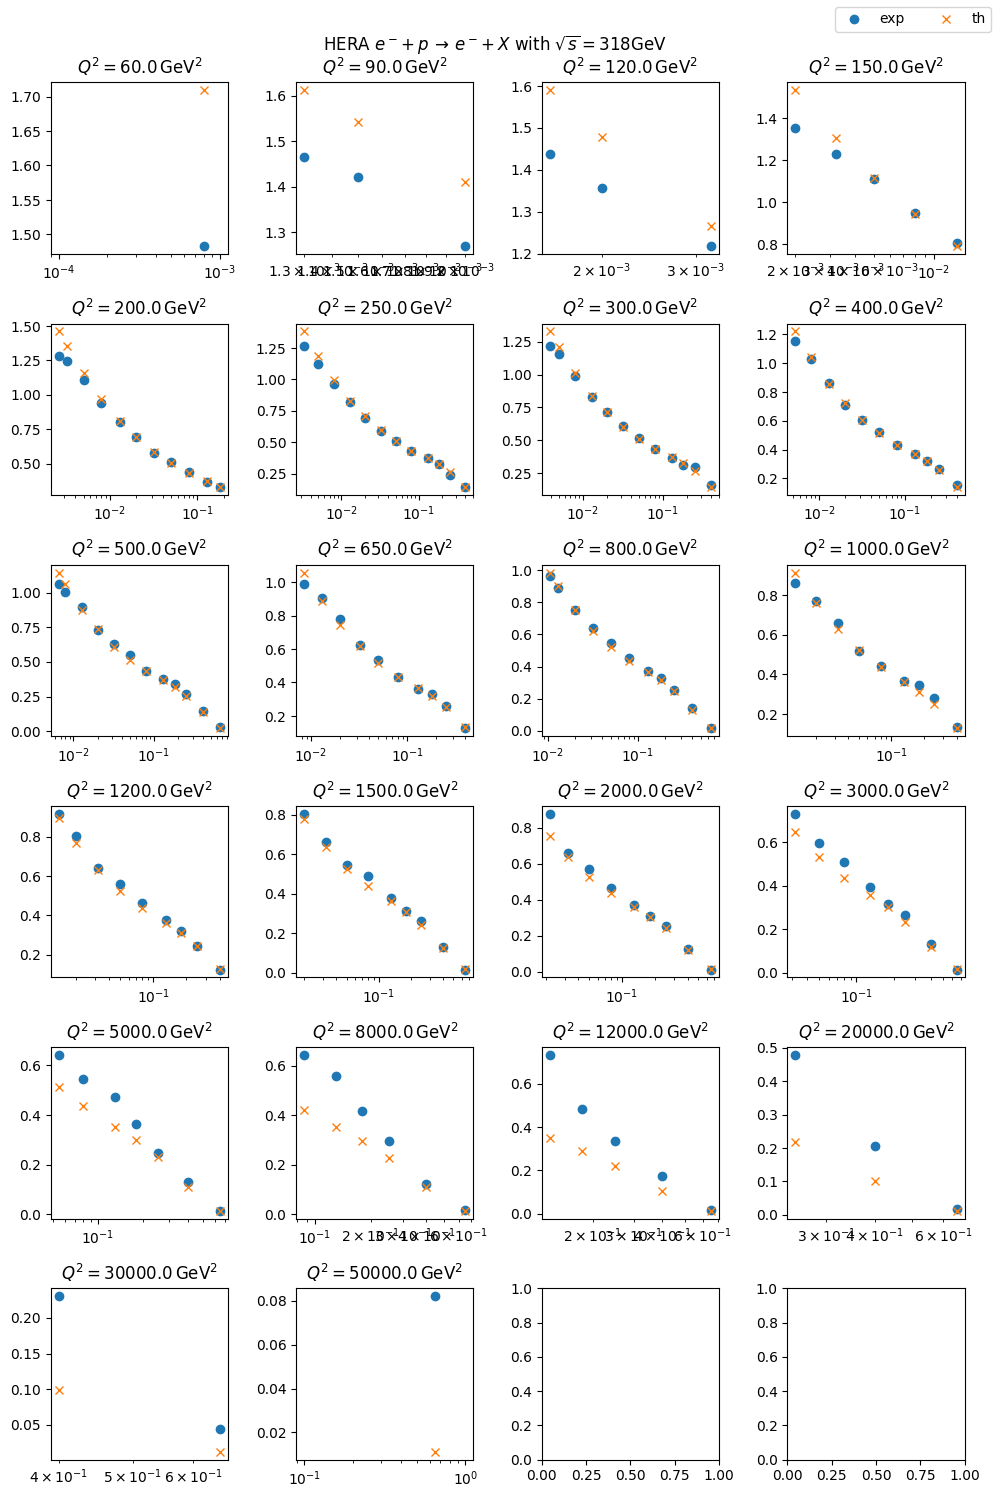

In [16]:
import matplotlib.pyplot as plt

# let's plot the experimental data against our predictions!
plt.close()
fig, axes = plt.subplots(6, 4, figsize=(10, 15), clear=True, layout="tight")
fig.suptitle(r"HERA $e^-\! + p \,\to\, e^-\! + X$ with $\sqrt{s}=318 \mathrm{GeV}$")
# the data is organised by Q2 - so let's make a plot for each value
for q2, ax in zip(f2_data["Q2"].unique(), axes.flatten()):
    # select the correct data
    dat = f2_data[f2_data["Q2"] == q2]
    ax.set_title(f"$Q^2 = {q2}\\,\\mathrm{{GeV}}^2$")
    # and plot
    (pexp,) = ax.plot(dat["x"], dat["Sigma"], "o", label="exp")
    (pth,) = ax.plot(dat["x"], dat["F2"], "x", label="th")
    # it is convenient to plot log(x) instead of just x
    ax.set_xscale("log")
fig.legend(handles=[pexp, pth], ncols=2);

Using a simple NLO calculation we can already see that we can get some decent agreement between theory and experiment which can give us some confidence that something is working. However, we also see that we do not match everywhere - so, instead of saying "a simple NLO calculation" we should say "a naive NLO calculation", because the full story behind DIS is much more complicated! This, we will discuss next. Note that we are not dealing with neither theoretical nor experimental uncertainties here.

# Computing more complete DIS measurements

As we said above, our calculation so far is fine for some points but a bit too simplistic and the full picture to compare with actual DIS
measurements is significantly more complex. We develop the [yadism](https://github.com/NNPDF/yadism) package to deal with these problems and next we want to hightlight some of these complications. 

## More leptons, hadrons, exchanged bosons and more structure functions

In our calculation above we assumed that an electron scatters of an proton with a virtual photon beeing exchanged and we implicitly assumed the photon has no logitudinal polarization - in yadism we can lift any of these assumptions.

Available leptons are the electron and the positron (as e.g. used at [HERA](https://en.wikipedia.org/wiki/HERA_(particle_accelerator))), but also
the neutrino and the anti-neutrino (as e.g. used at NuTeV at [Fermilab](https://en.wikipedia.org/wiki/Fermilab)).
However, since it is experimentally very challenging to control a neutrino beam, these are usually indirectly produced (see e.g. the [FPF proposal at CERN](https://arxiv.org/abs/2109.10905)).

We can use all types of hadrons: the most common target is, of course, protons (as e.g. used at [HERA](https://en.wikipedia.org/wiki/HERA_(particle_accelerator))), but also deuteron targets (as e.g. used at [SLAC](https://en.wikipedia.org/wiki/SLAC_National_Accelerator_Laboratory)) or nuclear targets, such as lead (as e.g. used at NuTeV at [Fermilab](https://en.wikipedia.org/wiki/Fermilab)). Especially the details on the internal structure of nuclei is a very active research topic at the moment which is a main focus of the proposed [EIC experiment](https://en.wikipedia.org/wiki/Electron%E2%80%93ion_collider).

As quarks and lepton carry both electric charges and electro-weak charges they can also scatter using electro-weak bosons in addition to the photon.
This leads to a fundamental distinction between two different types of DIS: we can either consider so-called Neutral Current (NC) DIS, where a boson without electric charge is exchanged (in the SM this corresponds to photons and Z-bosons), or Charged Current (CC) DIS, where an electrically chaged boson is exchanged (in the SM this corresponds to both W-bosons). As the coupling structure of those different types is completely different they probe different type of physics.

All in all, we can connect almost all particles (the Higgs is usually neglected in DIS experiments, as they do not operate at sufficient high energies) from the Standard model to the DIS process:
| DIS | Standard Model | 
| :-: | :-: |
| <img src="figures/pdg-dis.png" width=560 height=260 /> | <img src="figures/Standard_Model_of_Elementary_Particles.svg.png" width=260 height=260 /> |
| taken from [PDG](https://pdg.lbl.gov/2023/web/viewer.html?file=../reviews/rpp2022-rev-structure-functions.pdf) | taken from [Wikipedia](https://en.wikipedia.org/wiki/Standard_Model) |

As the exchanged boson is a virtual particle it does not only have a transversal polarization component, but also a longitudinal polarization component and we eventually have also to consider the spin structure of the particles. In practice this gives rise to three structure functions in total: $F_2$ (as discussed above), $F_L$ and $F_3$ - and all three can contribute to a total cross section (as measured in an experiment). In practice, experimentalists often normalize their measurements in such a way that the dominating contribution directly corresponds to $F_2$ (as is done in our example).

## Flavor number schemes (FNS)

In our calculation above we assumed there are 5 light quark flavors taking part in the scattering - this assumtions is only valid in a specific kinematic regime (this is exactly the region where we match the experimental data good). To be more precise: our calculation is valid if there is only a single relevant scale around (and that one scale is the virtuality $Q^2$) and there are five flavors actively running inside the proton.
The other scales one might want to (and has to) consider are the quark masses $M$: if $Q^2 \sim M^2$ we can not neglect these effects and we have to choose a different setup of the calculation. These considerations are commonly refered to as "Flavor Number Schemes" (FNS) and they are a common feature of higher order calculations (though in practice only relevant for DIS).

We can illustrate this with the following diagrams:
| light | heavy | 
| :-: | :-: |
| <img src="figures/lo-light.png" width=260 height=260 /> | <img src="figures/lo-heavy.png" width=260 height=260 /> |

In the first diagram (which we will call "light") the quark line refers to a massless quark of any flavor and this was the leading order diagram we used in our calculation above. The number of quark flavor which can enter this way into the calculation depends on the factorization scale: usually you consider a quark active if the factorization scale is above the quark mass.

Instead, in the second diagram (which we will call "heavy") the quark line refers to a massive quark with mass $M$ of a specific flavor.
Usually, one considers one quark at a time to be massive (while the others are either massless or infinitely massive). This diagrams generates terms which behave as $Q^2/M^2$, so exactly the ones which are relevant in the region $Q^2 \sim M^2$. However, we also know that in the limit of $Q^2 \to \infty$ we must have a connection to the first diagram, as we then can basically rewrite this diagram as the first diagram time a splitting $g\to q\bar q$.

There is no unique way to resolve this ambiguity and different PDF groups have adopted different strategies: [FONLL](https://inspirehep.net/literature/842785) for NNPDF, [S-ACOT](https://inspirehep.net/literature/524600) for CTEQ and [TR](https://inspirehep.net/literature/709470) for MSHT.

## Scale variations

In our calculation above we assumed there is only one scale in the game: the photon virtuality $Q^2$. Thus, we chose the renormalization scale $\mu_R$ used for the strong couping $\alpha_s(\mu_R^2)$ to coincide with $Q^2$ and, likewise, we chose the factorization scale $\mu_F$ used for the PDFs $f_j(z,\mu_F^2)$ to coincide with $Q^2$. Either scale is an *unphysical* scale that was introduced in the mathematical procedure of factorization and (UV) renormalization with the statement that they should be related to a "typical scale of the process". We can choose this freedom in order to vary them and to obtain an theoretical uncertainty which can be used to estimated [missing higher order uncertainties](https://inspirehep.net/literature/1741422).

Thus, we can write a more complete factorization formula:
$$
  \sigma(x,Q^2,\mu_F^2,\mu_R^2) = \sum_a\sum_{n=0} \left(\frac{\alpha_s(\mu_R^2)}{4\pi}\right)^n \int\limits_x^1 \frac{dz}{z} C_a^{(n)}(x/z, Q^2/\mu_F^2, Q^2/\mu_R^2) f_a^h(z,\mu_F^2)
$$

We can distinguish two different types of scale variations:
- renormalization scale variations: these are related to the (perturbative) invariance of the (physical) structure function upon the variation of the (unphysical) renomalization scale. This procedure can be directly related to the renormalization group equation (RGE) of the strong coupling: the beta function $\beta(\alpha_s)$ (more on this in the tutorial tomorrow!)
- factorization scale variations: these are related to the factorization procedure and they can be performed in several ways. Again this can be directly related to the RGE of the PDF: the DGLAP equation (more on this in the tutorial tomorrow!)

In either case we can write:

$$ \frac {d\sigma}{d\mu^2} = 0 \to \frac {d\sigma}{d\mu^2} = O(\alpha_s^{N+1}(\mu^2)) $$

so replacing the true independence with a higher order approximation.

## Comparing our implementation to yadism

In [17]:
from eko import interpolation
import copy
import yadism

# While yadism can indeed do much more, we can use it also to check our simple implementation from above!

# We need a "theory card" which describes all the theory settings,
# such as masses of quarks and bosons, or coupling reference values.
theory_card_simple = {
    "PTO": 1,
    "FNS": "FFNS",
    "DAMP": 0,
    "IC": 0,
    "IB": 0,
    "ModEv": "TRN",
    "ModSV": "unvaried",
    "XIR": 1.0,
    "XIF": 1.0,
    "NfFF": 5,
    "MaxNfAs": 5,
    "MaxNfPdf": 5,
    "Q0": 1.65,
    "alphas": 0.118,
    "Qref": 91.2,
    "nf0": 4,
    "nfref": 5,
    "QED": 0,
    "alphaqed": 0.007496252,
    "Qedref": 1.777,
    "SxRes": 0,
    "SxOrd": "LL",
    "HQ": "POLE",
    "mc": 1.51,
    "Qmc": 1.51,
    "kcThr": 1.0,
    "mb": 4.92,
    "Qmb": 4.92,
    "kbThr": 1.0,
    "mt": 172.5,
    "Qmt": 172.5,
    "ktThr": 1.0,
    "CKM": "0.97428 0.22530 0.003470 0.22520 0.97345 0.041000 0.00862 0.04030 0.999152",
    "MZ": 91.1876,
    "MW": 80.398,
    "GF": 1.1663787e-05,
    "SIN2TW": 0.23126,
    "TMC": 0,
    "MP": 0.938,
    "global_nx": 0,
    "EScaleVar": 1,
    "kDIScThr": 1.0,
    "kDISbThr": 1.0,
    "kDIStThr": 1.0,
    "n3lo_cf_variation": 0,
}
# We also need an "observable card" which tells us *what* we want to compute
observables_card_simple = {
    "PolarizationDIS": 0.0,
    "ProjectileDIS": "electron",
    "PropagatorCorrection": 0.0,
    "TargetDIS": "proton",
    "interpolation_is_log": True,
    "interpolation_polynomial_degree": 4,
    "interpolation_xgrid": interpolation.lambertgrid(60).tolist(),
    "observables": {"F2_light": []},
    "prDIS": "EM",
    "NCPositivityCharge": None,
}
yadism.log.silent_mode = True


def compare(curobs: list) -> pd.DataFrame:
    """Compare local implementation against yadism for given observables."""
    obs_card = copy.deepcopy(observables_card_simple)
    # The limit, in which we were computing above, is called F2_light inside yadism
    obs_card["observables"]["F2_light"] = curobs
    out = yadism.run_yadism(theory_card_simple, obs_card)
    # as yadism produces a grid, we still need to apply the PDF
    yad_data = out.apply_pdf_alphas_alphaqed_xir_xif(
        pdf, pdf.alphasQ, lambda _: 0.0, 1.0, 1.0
    )
    cmp = []
    for dat in yad_data["F2_light"]:
        # let's compute our own numbers
        me = f2(dat["x"], dat["Q2"])
        # and compare
        cmp.append(
            dict(
                x=dat["x"],
                Q2=dat["Q2"],
                yadism=dat["result"],
                F2=me,
                ratio=me / dat["result"],
            )
        )
    return pd.DataFrame.from_records(cmp)


# let's take some random points in x and Q2 for our comparison
yadism_vs_f2 = compare(
    [
        {"x": 0.001, "Q2": 10},
        {"x": 0.001, "Q2": 100},
        {"x": 0.001, "Q2": 1000},
        {"x": 0.01, "Q2": 100},
        {"x": 0.1, "Q2": 100},
    ]
)

┌────────────────────────────────────┐                                       
                                      │                                    │                                       
                                      │ __     __       _ _                │                                       
                                      │ \ \   / /      | (_)               │                                       
                                      │  \ \_/ /_ _  __| |_ ___ _ __ ___   │                                       
                                      │   \   / _` |/ _` | / __| '_ ` _ \  │                                       
                                      │    | | (_| | (_| | \__ \ | | | | | │                                       
                                      │    |_|\__,_|\__,_|_|___/_| |_| |_| │                                       
                                      │                                    │                                       
                                      └────────────────────────────────────┘

Plan

 • F2_light at 5 pts

Calculation

yadism took off! please stay tuned ...

Output()

/Users/evagroenendijk/anaconda3/envs/nnpdf_env/lib/python3.11/site-packages/yadism/esf/conv.py:151: 
IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  res, err = scipy.integrate.quad(
Computing F2_light ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  20% -:--:--

took 13.99 s

/var/folders/m9/3gg_f2x974x0vtn80m668d3c0000gn/T/ipykernel_9037/2712947663.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  regsing = quad(ker, x, 1.0, args=(c, f, x), points=(1.0))[0]
/var/folders/m9/3gg_f2x974x0vtn80m668d3c0000gn/T/ipykernel_9037/2712947663.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  regsing = quad(ker, x, 1.0, args=(c, f, x), points=(1.0))[0]


In [18]:
yadism_vs_f2
# The remaining difference is most likely a left-over from the interpolation inside yadism

,x,Q2,yadism,F2,ratio
0,0.001,10,1.018839,1.018974,1.000132
1,0.001,100,1.779307,1.779620,1.000176
2,0.001,1000,2.529417,2.529938,1.000206
3,0.010,100,0.833643,0.833730,1.000104
4,0.100,100,0.402391,0.402388,0.999993


## Compare yadism to data

In [19]:
from yadbox.export import dump_pineappl_to_file

# Let's activate the full complications and recompute!

theory_card_full = {
    "PTO": 2,
    "FNS": "FONLL-C",
    "DAMP": 0,
    "IC": 1,
    "IB": 0,
    "ModEv": "TRN",
    "ModSV": "unvaried",
    "XIR": 1.0,
    "XIF": 1.0,
    "NfFF": 5,
    "MaxNfAs": 5,
    "MaxNfPdf": 5,
    "Q0": 1.65,
    "alphas": 0.118,
    "Qref": 91.2,
    "nf0": 4,
    "nfref": 5,
    "QED": 0,
    "alphaqed": 0.007496252,
    "Qedref": 1.777,
    "SxRes": 0,
    "SxOrd": "LL",
    "HQ": "POLE",
    "mc": 1.51,
    "Qmc": 1.51,
    "kcThr": 1.0,
    "mb": 4.92,
    "Qmb": 4.92,
    "kbThr": 4.0,
    "mt": 172.5,
    "Qmt": 172.5,
    "ktThr": 1.0,
    "CKM": "0.97428 0.22530 0.003470 0.22520 0.97345 0.041000 0.00862 0.04030 0.999152",
    "MZ": 91.1876,
    "MW": 80.398,
    "GF": 1.1663787e-05,
    "SIN2TW": 0.23126,
    "TMC": 1,
    "MP": 0.938,
    "global_nx": 0,
    "EScaleVar": 1,
    "kDIScThr": 1.0,
    "kDISbThr": 4.0,
    "kDIStThr": 1.0,
}
observables_card_full = {
    "PolarizationDIS": 0.0,
    "ProjectileDIS": "electron",
    "PropagatorCorrection": 0.0,
    "TargetDIS": "proton",
    "interpolation_is_log": True,
    "interpolation_polynomial_degree": 4,
    "interpolation_xgrid": interpolation.lambertgrid(60).tolist(),
    "observables": {"XSHERANC_total": []},
    "prDIS": "NC",
    "NCPositivityCharge": None,
}


def compute():
    """Compute yadism prediction for all experimental bins."""
    obs_card = copy.deepcopy(observables_card_full)
    # collect all kinematics
    curobs = data.apply(
        lambda dat: {"x": dat["x"], "Q2": dat["Q2"], "y": dat["y"]},
        axis=1,
    )
    obs_card["observables"]["XSHERANC_total"] = list(curobs.to_dict().values())
    out = yadism.run_yadism(theory_card_full, obs_card)
    # let's dump the grid, which we can reuse
    dump_pineappl_to_file(
        out, "HERA_NC_318GEV_EM_SIGMARED.pineappl.lz4", "XSHERANC_total"
    )


# Attention! Since we're asking for a more complicated thing the calculation will actually take a bit (~20min) ...
# compute()

In [20]:
# Let's load the precomputed grid instead!
# we load it ...
grid = pineappl.grid.Grid.read("HERA_NC_318GEV_EM_SIGMARED.pineappl.lz4")
# and convolute it with the PDF - finish!
yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

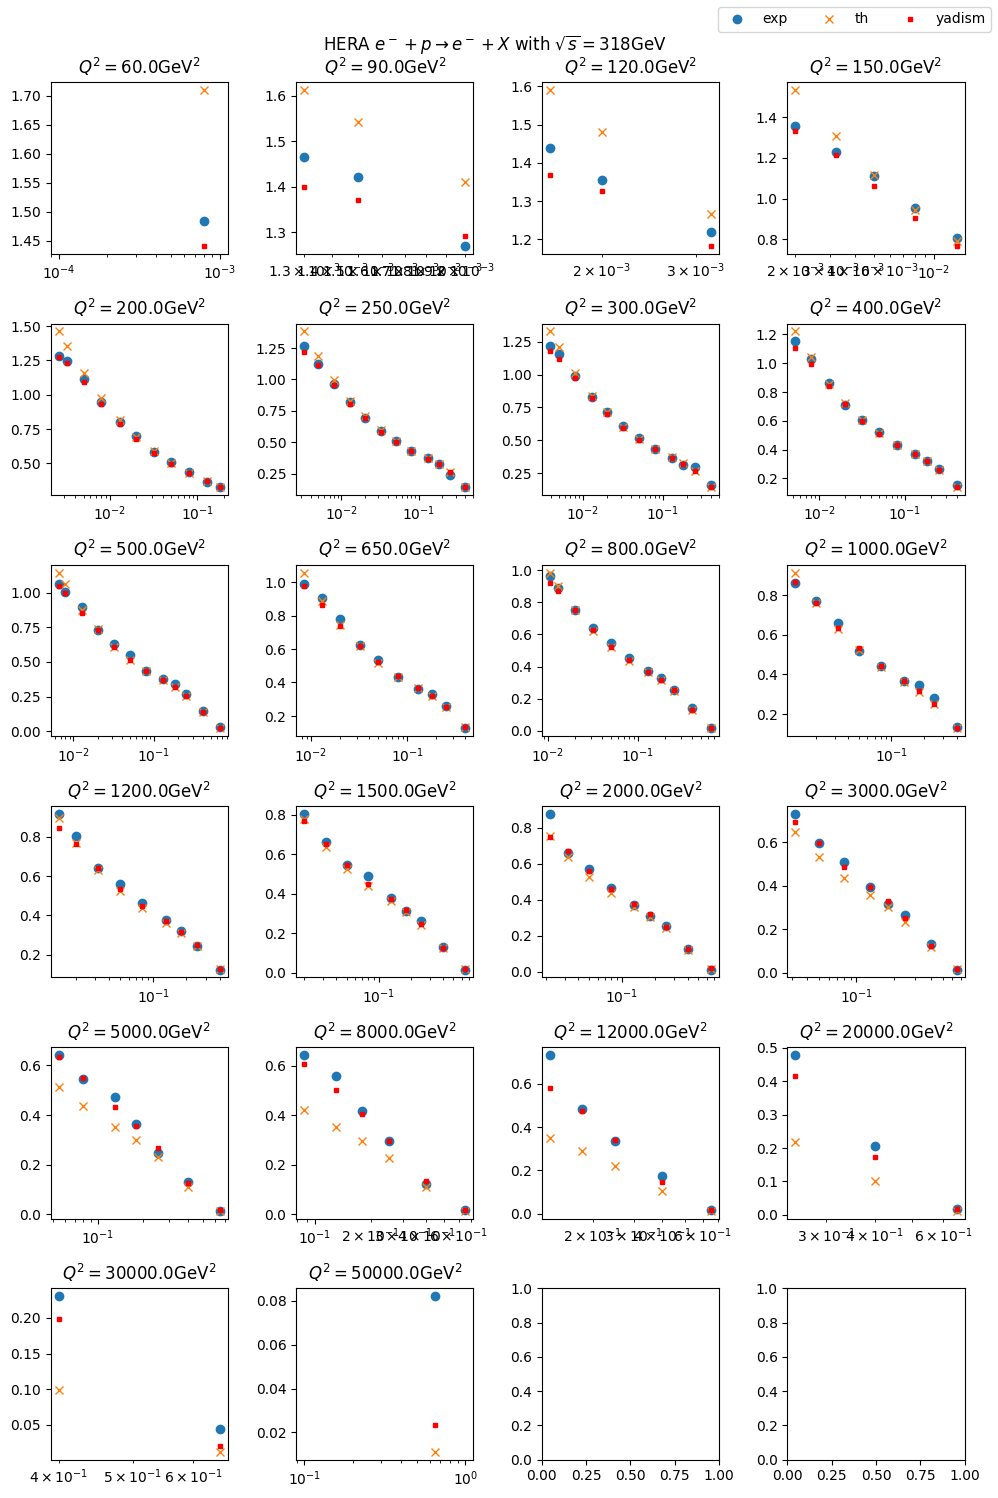

In [21]:
# let's plot the experimental data against our predictions!
plt.close()
# let's join the experimental numbers, our numbers computed above, and yadism
plot_data = pd.concat(
    [
        data["Q2"],
        data["x"],
        data["Sigma"],
        f2_data["F2"],
        pd.DataFrame([yadism_data], index=["yadism"]).T,
    ],
    axis=1,
)
fig, axes = plt.subplots(6, 4, figsize=(10, 15), clear=True, layout="tight")
fig.suptitle(r"HERA $e^- + p \to e^- + X$ with $\sqrt{s}=318 \mathrm{GeV}$")
# again, iterate by Q2
for q2, ax in zip(plot_data["Q2"].unique(), axes.flatten()):
    dat = plot_data[plot_data["Q2"] == q2]
    ax.set_title(f"$Q^2 = {q2} \\mathrm{{GeV}}^2$")
    # now, we can compare the three numbers: from experiment, from above, and from yadism
    (pexp,) = ax.plot(dat["x"], dat["Sigma"], "o", label="exp")
    (pth,) = ax.plot(dat["x"], dat["F2"], "x", label="th")
    (pyad,) = ax.plot(dat["x"], dat["yadism"], "rs", label="yadism", markersize=3)
    ax.set_xscale("log")
fig.legend(handles=[pexp, pth, pyad], ncols=3);

We can see some improvement in the small $Q^2$ region, where our naive implementation was missing charm mass effects, and some improvements in the large
$Q^2$ region, where, instead, we were missing electro-weak corrections (from the Z-boson).

Note that we are not dealing with uncertainties here, neither on the experimental side nor on the theory side.